In [4]:
from stock_helper import *
from stock_stats import *
from product_info import *
from imp import reload  
import stock_helper
import stock_stats
reload(stock_helper)
reload(stock_stats)


<module 'stock_stats' from 'C:\\Users\\dell\\stock_stats.py'>

In [5]:
import warnings
 
warnings.filterwarnings('ignore')

In [6]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [7]:
product_list = ["600519", "000858", "000568", "600809", "002304"]

In [8]:
period = 4096

In [9]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)


In [11]:
SAVE_PATH = "e:/intern"
all_dates_x = os.listdir(DATA_PATH + product_list[0])
all_dates_y = os.listdir(DATA_PATH + product_list[1])
all_dates = np.array(list(set(all_dates_x) & set(all_dates_y)))
all_dates.sort()
train_sample = all_dates<"2017"
test_sample = all_dates>"2017"


In [12]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [14]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [15]:
train_sample = all_dates<"2017"
test_sample = all_dates>"2017"

In [16]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)
#y_signal = "ret."+str(period)

- at first we try using lasso for them together 

In [17]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-4]
signal_names
col_names = ori_mat.columns

In [18]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[signal_names]
#train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=signal_names)
train_mat.shape
## (1001, 28)

(1001, 28)

In [22]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

# 000858 (1281, 32)
# 000568 (1007, 32)
# 600809 (756, 32)
# 002304 (838, 32)







000858 (1281, 32)
000568 (1007, 32)
600809 (756, 32)
002304 (838, 32)


In [23]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [24]:
x_train = train_mat.iloc[:, :n_signal].values
#x_train = train_mat[result["chosen.signals"]]
#x_train = train_mat[signal_list[chosen_signals]]
y_train = train_mat.loc[:, y_signal].values
print(np.shape(x_train))
scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = np.zeros(n_signal)
#fit_coef[pos] = model.coef_/x_std
fit_coef = model.coef_/x_std
print(fit_coef)

# (4883, 28)
# [ 0.04021563  0.          0.04836435  0.03710987 -0.24008393  0.05448985
#  -0.          0.         -0.00153232 -0.0543311  -0.06632444  0.1646846
#   0.         -0.02927534 -0.00613259 -0.08949701 -0.04963615 -0.03753758
#  -0.          0.03122811 -0.          0.         -0.          0.
#   0.          0.10643397  0.         -0.        ]




(4883, 28)
[ 0.04021563  0.          0.04836435  0.03710987 -0.24008393  0.05448985
 -0.          0.         -0.00153232 -0.0543311  -0.06632444  0.1646846
  0.         -0.02927534 -0.00613259 -0.08949701 -0.04963615 -0.03753758
 -0.          0.03122811 -0.          0.         -0.          0.
  0.          0.10643397  0.         -0.        ]


In [25]:
coef_list=dict([])
for product in product_list:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])
    
# 600519
# nr.4096                       0.050641
# range.pos.4096                0.007250
# price.osci.4096               0.001757
# ma.dif.10.4096               -0.327430
# kdj.k.4096                    0.002470
# dbook.range.4096             -0.000045
# range.pos.range.4096         -0.000767
# price.osci.range.4096        -0.000311
# ma.dif.10.range.4096          0.012314
# kdj.j.range.4096             -0.000130
# nr.std.4096                  -0.002243
# dbook.std.4096               -0.010288
# range.pos.std.4096           -0.002674
# price.osci.std.4096          -0.000686
# kdj.k.std.4096                0.000467
# ma.dif.10.trend.index.4096    0.220080
# dtype: float64
# 000858
# nr.4096                       0.045838
# range.pos.4096                0.007194
# price.osci.4096               0.001703
# ma.dif.10.4096               -0.336244
# kdj.k.4096                    0.002427
# dbook.range.4096             -0.000365
# range.pos.range.4096         -0.007550
# price.osci.range.4096        -0.002939
# ma.dif.10.range.4096          0.108104
# kdj.j.range.4096             -0.001280
# nr.std.4096                  -0.020465
# dbook.std.4096               -0.081690
# range.pos.std.4096           -0.025413
# price.osci.std.4096          -0.006380
# kdj.k.std.4096                0.004544
# ma.dif.10.trend.index.4096    0.223478
# dtype: float64
# 000568
# nr.4096                       0.066597
# range.pos.4096                0.009677
# price.osci.4096               0.002325
# ma.dif.10.4096               -0.346137
# kdj.k.4096                    0.003258
# dbook.range.4096             -0.000436
# range.pos.range.4096         -0.007165
# price.osci.range.4096        -0.002810
# ma.dif.10.range.4096          0.093062
# kdj.j.range.4096             -0.001229
# nr.std.4096                  -0.020484
# dbook.std.4096               -0.099785
# range.pos.std.4096           -0.024853
# price.osci.std.4096          -0.006289
# kdj.k.std.4096                0.004261
# ma.dif.10.trend.index.4096    0.233006
# dtype: float64
# 600809
# nr.4096                       0.089060
# range.pos.4096                0.012490
# price.osci.4096               0.003058
# ma.dif.10.4096               -0.318772
# kdj.k.4096                    0.004298
# dbook.range.4096             -0.000236
# range.pos.range.4096         -0.003832
# price.osci.range.4096        -0.001567
# ma.dif.10.range.4096          0.036583
# kdj.j.range.4096             -0.000669
# nr.std.4096                  -0.010569
# dbook.std.4096               -0.051949
# range.pos.std.4096           -0.012321
# price.osci.std.4096          -0.003378
# kdj.k.std.4096                0.002267
# ma.dif.10.trend.index.4096    0.210961
# dtype: float64
# 002304
# nr.4096                       0.082797
# range.pos.4096                0.012157
# price.osci.4096               0.002782
# ma.dif.10.4096               -0.318603
# kdj.k.4096                    0.004204
# dbook.range.4096             -0.000085
# range.pos.range.4096         -0.001004
# price.osci.range.4096        -0.000395
# ma.dif.10.range.4096          0.004296
# kdj.j.range.4096             -0.000187
# nr.std.4096                  -0.000705
# dbook.std.4096               -0.015437
# range.pos.std.4096           -0.002544
# price.osci.std.4096          -0.000651
# kdj.k.std.4096                0.000475
# ma.dif.10.trend.index.4096    0.180371
# dtype: float64

600519
nr.4096                       0.050641
range.pos.4096                0.007250
price.osci.4096               0.001757
ma.dif.10.4096               -0.327430
kdj.k.4096                    0.002470
dbook.range.4096             -0.000045
range.pos.range.4096         -0.000767
price.osci.range.4096        -0.000311
ma.dif.10.range.4096          0.012314
kdj.j.range.4096             -0.000130
nr.std.4096                  -0.002243
dbook.std.4096               -0.010288
range.pos.std.4096           -0.002674
price.osci.std.4096          -0.000686
kdj.k.std.4096                0.000467
ma.dif.10.trend.index.4096    0.220080
dtype: float64
000858
nr.4096                       0.045838
range.pos.4096                0.007194
price.osci.4096               0.001703
ma.dif.10.4096               -0.336244
kdj.k.4096                    0.002427
dbook.range.4096             -0.000365
range.pos.range.4096         -0.007550
price.osci.range.4096        -0.002939
ma.dif.10.range.4096          0.108

In [26]:
SAVE_PATH = "e:/intern"
save(coef_list, SAVE_PATH+"/wine.lasso.pkl")

In [27]:
coef_list = load(SAVE_PATH+"/wine.lasso.pkl")

In [28]:
strat = "overall.wine.lasso."+str(period)
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [29]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")

# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 5min 53s




600519
000858
000568
600809
002304
Wall time: 5min 53s


In [30]:
%%time
for product in product_list:
    print(product)
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 5.67 s

600519
000858
000568
600809
002304
Wall time: 5.67 s


In [31]:
%%time
for product in product_list:
    evaluate_signal("overall.wine.lasso", all_dates, product, 0.001, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                        period=4096, split_str="2017",atr_filter=0.02, save_path="signal result atr", reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 22min 41s







reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 22min 41s


In [32]:
for product in product_list:
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"overall.wine.lasso.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    
# 600519 train sharpe  nan test sharpe  nan
# 000858 train sharpe  0.4669093719311658 test sharpe  -0.8716039046530267
# 000568 train sharpe  nan test sharpe  nan
# 600809 train sharpe  nan test sharpe  nan
# 002304 train sharpe  0.20222115231614435 test sharpe  -0.3402588444265122


600519 train sharpe  nan test sharpe  nan
000858 train sharpe  0.4669093719311658 test sharpe  -0.8716039046530267
000568 train sharpe  nan test sharpe  nan
600809 train sharpe  nan test sharpe  nan
002304 train sharpe  0.20222115231614435 test sharpe  -0.3402588444265122


- we can see that the result is much better than before
- so we can use this method for rolling models
- However, using the previous method may be too slow
- we calcualte the predictions values of each product using 26 mintues, and other time add up together would be 30 mintues
- if we are rolling on a monthly basis
- from 201801 to 201908 there are 20 months
- so it may use 10 hours for the rolling

- rolling model

- at first we need to know how many ticks every day

In [33]:
## construct the signal matrix
## we want to put multiple signals into a matrix
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample]) ## tottal number of samples
    n_signal = len(signal_list) ## number of signals, the matrix would be n_samples*n_signal
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        data = load(HEAD_PATH+"/stock pkl/"+product+"/"+file)
        chosen = (np.arange(np.shape(data)[0])+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [34]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

- at first we can try a not so intensive method
- we can get the starting day for train

In [35]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV

- at first we can try a not so intensive method
- we can get the starting day for train

In [36]:
from sklearn.preprocessing import StandardScaler

- now we generate prediction values for next 22 days

- now we can combien all these and get a function for rolling
- we can also use calendar month rather than 22 days

In [37]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, strat, 
                          product_list, all_dates, daily_num, signal_list, period=4096, SAVE_PATH="e:/intern"):
    scaler =  StandardScaler(copy=True, with_mean=True, with_std=True)
    coef_list = dict([])
    train_std_mat = dict([])
    y_std = dict([])
    n_signal = len(signal_list)
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    train_start = 0
    train_end = 2
    sample  =(all_dates>=all_dates[train_start]) & (all_dates<=all_dates[train_end])
    for product in product_list: ## combine data sets together and then fit the model
        print(product)
        train = get_sample_signal(all_dates, sample, product, np.append(signal_list, y_signal), period, daily_ticks[product])
        x_train = train.iloc[:,:n_signal]
        scaler.fit(x_train)
        cur_y_train = train[y_signal]
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    x_train = train_mat
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    #fit_coef = np.zeros(n_signal)
    #fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    fit_coef = model.coef_/x_std
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in product_list:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [38]:
all_dates

array(['2011.pkl', '2012.pkl', '2013.pkl', '2014.pkl', '2015.pkl',
       '2016.pkl', '2017.pkl', '2018.pkl', '2019.pkl', '2020.pkl',
       '2021.pkl'], dtype='<U8')

In [39]:
%%time
strat = "roll.wine.lasso.4096" ## with double normalization
y_signal = "ret.4096.002"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    get_multiple_lasso_roll_model(train_start, train_end, y_signal, strat+"."+all_dates[train_start], 
                          product_list, all_dates, daily_num, signal_list)
    train_start = train_start+1
    train_end = train_end+1
    
# 2011.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2012.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2013.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2014.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2015.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2016.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# 2017.pkl
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 10min 43s

2011.pkl
600519
000858
000568
600809
002304
2012.pkl
600519
000858
000568
600809
002304
2013.pkl
600519
000858
000568
600809
002304
2014.pkl
600519
000858
000568
600809
002304
2015.pkl
600519
000858
000568
600809
002304
2016.pkl
600519
000858
000568
600809
002304
2017.pkl
600519
000858
000568
600809
002304
Wall time: 10min 43s


- Then we can generate prediction values of each model

In [40]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    strat_name = strat+"."+all_dates[train_start]
    coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list:
        coef = coef_list[product]
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        ## each model has training set from train_start to train_end, and a test set until train_end+forward_len, so 
        ## we need to generate values of all_dates[train_start:(train_end+forward_len)+1], plus 1 to include train_end+forward_len
        parLapply(CORE_NUM, all_dates[train_start:(train_end+2)], par_get_daily_pred, 
                  product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern",SAVE_PATH="e:/intern")
    train_end = train_end+1

# 2011.pkl
# 2012.pkl
# 2013.pkl
# 2014.pkl
# 2015.pkl
# 2016.pkl
# 2017.pkl
# Wall time: 7min 29s


2011.pkl
2012.pkl
2013.pkl
2014.pkl
2015.pkl
2016.pkl
2017.pkl
Wall time: 7min 29s


In [41]:
%%time
strat = "roll.wine.lasso.4096"
train_end = 6
for train_start in range(7):
    print(all_dates[train_start])
    ## we only generte distribution on training set, not on test set
    for product in product_list:
        par_get_all_signal(strat+"."+all_dates[train_start], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    train_end = train_end+1
    
# 2011.pkl
# 2012.pkl
# 2013.pkl
# 2014.pkl
# 2015.pkl
# 2016.pkl
# 2017.pkl
# Wall time: 38 s



2011.pkl
2012.pkl
2013.pkl
2014.pkl
2015.pkl
2016.pkl
2017.pkl
Wall time: 38 s


In [46]:
## get rolling statistics of the strategy performance
def get_lasso_roll_result(product, strat,train_range, train_end, atr_filter=0, save_path="signal result atr", 
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    for train_start in range(train_range):
        strat_name = strat+"."+all_dates[train_start]
        print(product, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl,
                                 product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1,
                                 HEAD_PATH=HEAD_PATH, SAVE_PATH=SIGNAL_PATH,atr_filter=atr_filter)
        train_stat = get_hft_summary(train_result, thre_mat)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+2)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1,
                            HEAD_PATH=HEAD_PATH, SAVE_PATH=SIGNAL_PATH, atr_filter=atr_filter)
        test_stat = get_hft_summary(test_result, thre_mat)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_end = train_end+1

In [48]:
%%time
strat = "roll.wine.lasso.4096"
for product in product_list:
    get_lasso_roll_result(product, strat,4, 6, atr_filter=0.02)

# 600519 roll.wine.lasso.4096.2011.pkl
# 600519 roll.wine.lasso.4096.2012.pkl
# 600519 roll.wine.lasso.4096.2013.pkl
# 600519 roll.wine.lasso.4096.2014.pkl
# 000858 roll.wine.lasso.4096.2011.pkl
# 000858 roll.wine.lasso.4096.2012.pkl
# 000858 roll.wine.lasso.4096.2013.pkl
# 000858 roll.wine.lasso.4096.2014.pkl
# 000568 roll.wine.lasso.4096.2011.pkl
# 000568 roll.wine.lasso.4096.2012.pkl
# 000568 roll.wine.lasso.4096.2013.pkl
# 000568 roll.wine.lasso.4096.2014.pkl
# 600809 roll.wine.lasso.4096.2011.pkl
# 600809 roll.wine.lasso.4096.2012.pkl
# 600809 roll.wine.lasso.4096.2013.pkl
# 600809 roll.wine.lasso.4096.2014.pkl
# 002304 roll.wine.lasso.4096.2011.pkl
# 002304 roll.wine.lasso.4096.2012.pkl
# 002304 roll.wine.lasso.4096.2013.pkl
# 002304 roll.wine.lasso.4096.2014.pkl
# Wall time: 1h 26min 37s


600519 roll.wine.lasso.4096.2011.pkl
600519 roll.wine.lasso.4096.2012.pkl
600519 roll.wine.lasso.4096.2013.pkl
600519 roll.wine.lasso.4096.2014.pkl
000858 roll.wine.lasso.4096.2011.pkl
000858 roll.wine.lasso.4096.2012.pkl
000858 roll.wine.lasso.4096.2013.pkl
000858 roll.wine.lasso.4096.2014.pkl
000568 roll.wine.lasso.4096.2011.pkl
000568 roll.wine.lasso.4096.2012.pkl
000568 roll.wine.lasso.4096.2013.pkl
000568 roll.wine.lasso.4096.2014.pkl
600809 roll.wine.lasso.4096.2011.pkl
600809 roll.wine.lasso.4096.2012.pkl
600809 roll.wine.lasso.4096.2013.pkl
600809 roll.wine.lasso.4096.2014.pkl
002304 roll.wine.lasso.4096.2011.pkl
002304 roll.wine.lasso.4096.2012.pkl
002304 roll.wine.lasso.4096.2013.pkl
002304 roll.wine.lasso.4096.2014.pkl
Wall time: 1h 26min 37s


sharpe  0.6170409766869058
sharpe  0.8702865993204729
sharpe  0.6180900486403302
sharpe  -0.022440496999095345
sharpe  0.15888315030395214


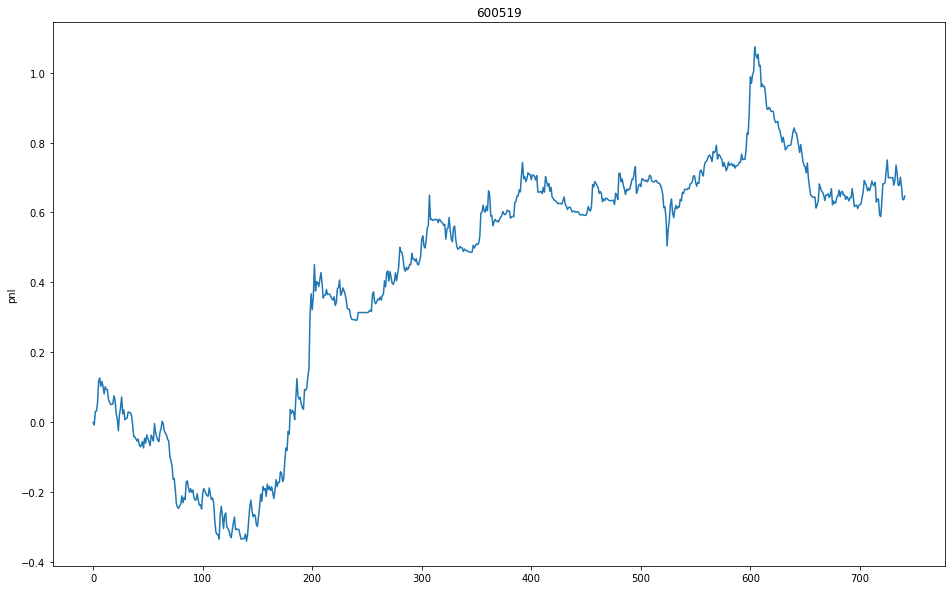

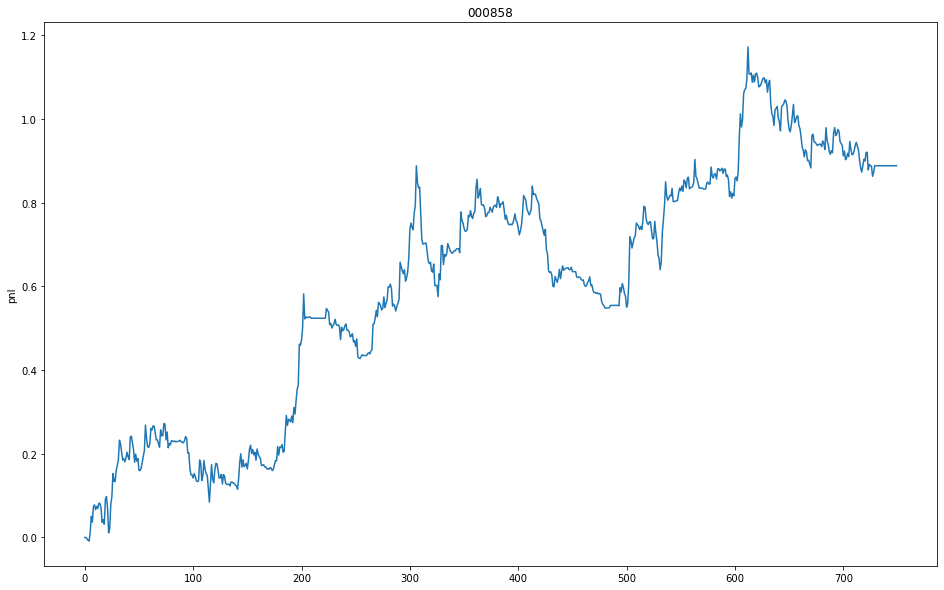

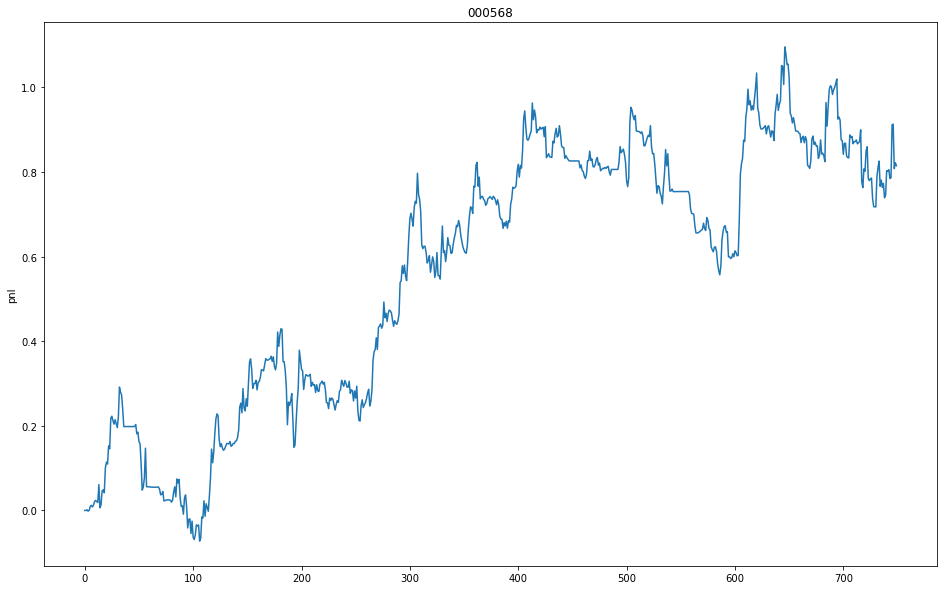

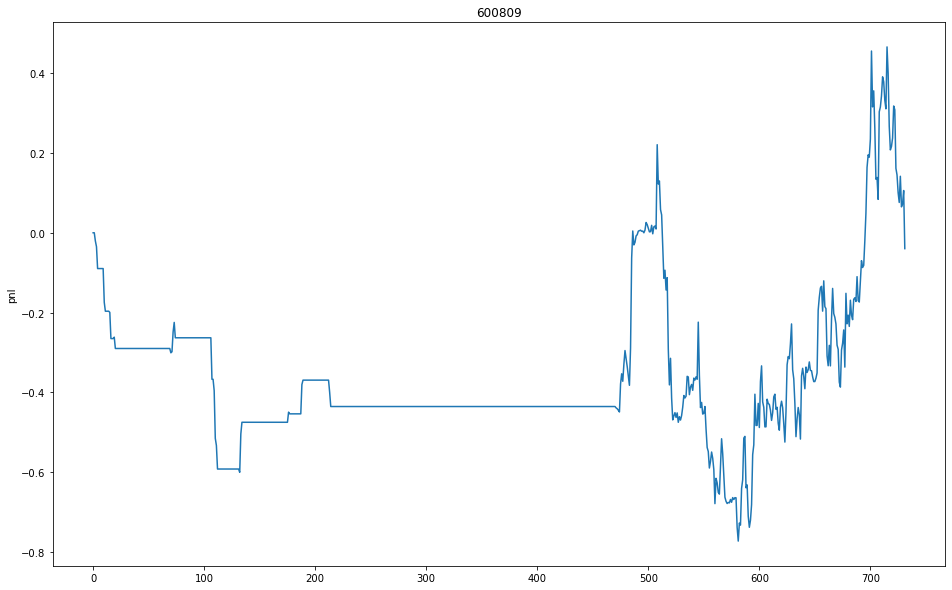

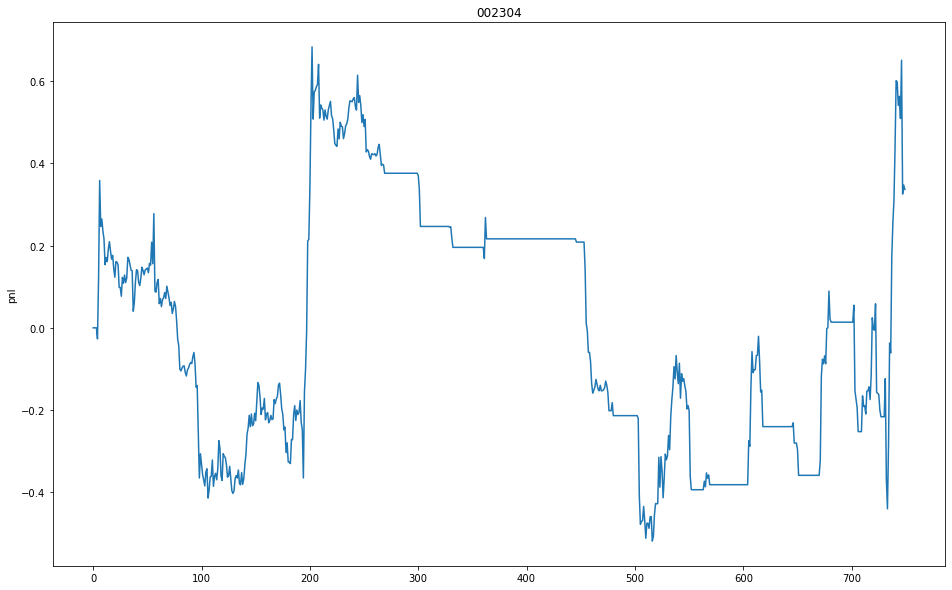

In [50]:
n_product = len(product_list)
save_path = "signal result atr"
strat = "roll.wine.lasso.4096"
start_month = 0
min_pnl = 0.001
min_num = 10

train_end = 6
for i_product in range(n_product):
    all_pnl = np.array([])    
    for train_start in range(4):
        strat_name = strat+"."+all_dates[train_start]
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        good_strat = (train_stat["final.result"]["avg.ret"]>min_pnl) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        all_pnl = np.append(all_pnl, test_pnl)
    plt.figure(i_product, figsize=(16, 10))
    plt.title(product_list[i_product])
    plt.ylabel("pnl")
    plt.plot(all_pnl.cumsum());
    print("sharpe ", sharpe(all_pnl))

# sharpe  0.6170409766869058
# sharpe  0.8702865993204729
# sharpe  0.6180900486403302
# sharpe  -0.022440496999095345
# sharpe  0.15888315030395214


